# COSC102 Group Assignment 3
# Machine Learning Portfolio

# Group Members - Will Duckworth, Jim Purvis

# KNN Classifier, RandomForest Classifier, SGD Classifier, Neural Network

- This notebook contains a machine learning workflow using the provided raw IMU data, 4 classification algorithms, and a performance comparison.

# Import necessary libraries
- If tensorflow and mlxtend libraries are not already installed, please uncomment and run the cell below for installation.

In [2]:
# !pip install tensorflow
# !pip install mlxtend

In [3]:
import csv
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import statistics
from sklearn import preprocessing, metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import neighbors
from sklearn.metrics import plot_confusion_matrix as plot_cm
from mlxtend.plotting import plot_confusion_matrix as plot_nn_cm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
import tensorflow as tf

# *** Data Preparation ***

Contributor: Team effort

## Set the file paths for the 2 data sets to be read
## Convert the data to a Pandas DataFrame

In [4]:
imu_data_path = os.path.abspath("a3_imu_data.csv")

annotations_path = os.path.abspath("a3_activity_annotations.csv")

imu_data = pd.read_csv(imu_data_path, delimiter=",")

imu_data_frame = pd.DataFrame(data=imu_data)

annotations_data = pd.read_csv(annotations_path, delimiter=",")

annotations_data_frame = pd.DataFrame(data=annotations_data)

## Create empty lists to store the separated data for each of the activity set data points

In [5]:
time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []

## Create function to map the activity type and return an integer value for that activity

In [6]:
def map_activity(activity_string):
    if activity_string == 'Standing':
        return 0
    elif activity_string == 'Walking':
        return 1
    elif activity_string == 'Jogging':
        return 2
    elif activity_string == 'Side-Step':
        return 3
    elif activity_string == 'Running':
        return 4

## Read in the data as a CSV, and append the lists depending on the label

In [7]:
with open(imu_data_path, newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        time_track.append(float(row[0]))
        ax_set.append(float(row[1]))
        ay_set.append(float(row[2]))
        az_set.append(float(row[3]))
        gx_set.append(float(row[4]))
        gy_set.append(float(row[5]))
        gz_set.append(float(row[6]))

## Create a color list to visualise the data from the plot

Text(0, 0.5, 'Value')

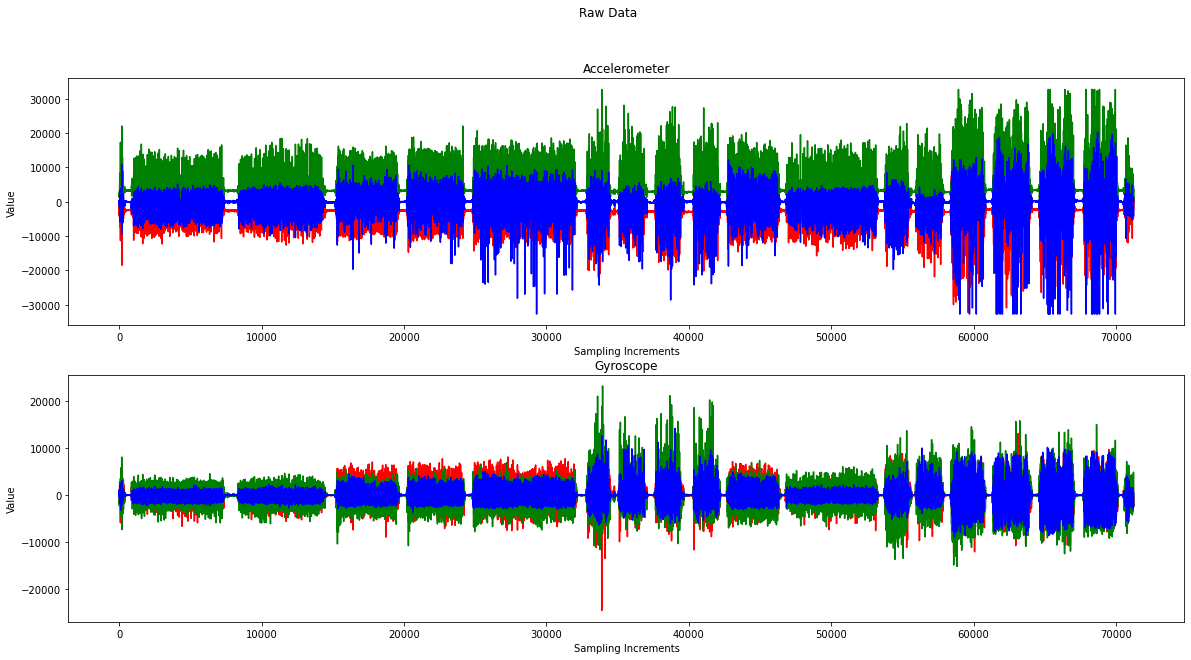

In [8]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
fig.suptitle("Raw Data")
axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')
axs[0].set_title("Accelerometer")
axs[0].set_xlabel("Sampling Increments")
axs[0].set_ylabel("Value")

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')
axs[1].set_title("Gyroscope")
axs[1].set_xlabel("Sampling Increments")
axs[1].set_ylabel("Value")

## Cut the data to the starting point of the activity, removing prior noise and sync the data to the video

Text(0, 0.5, 'Value')

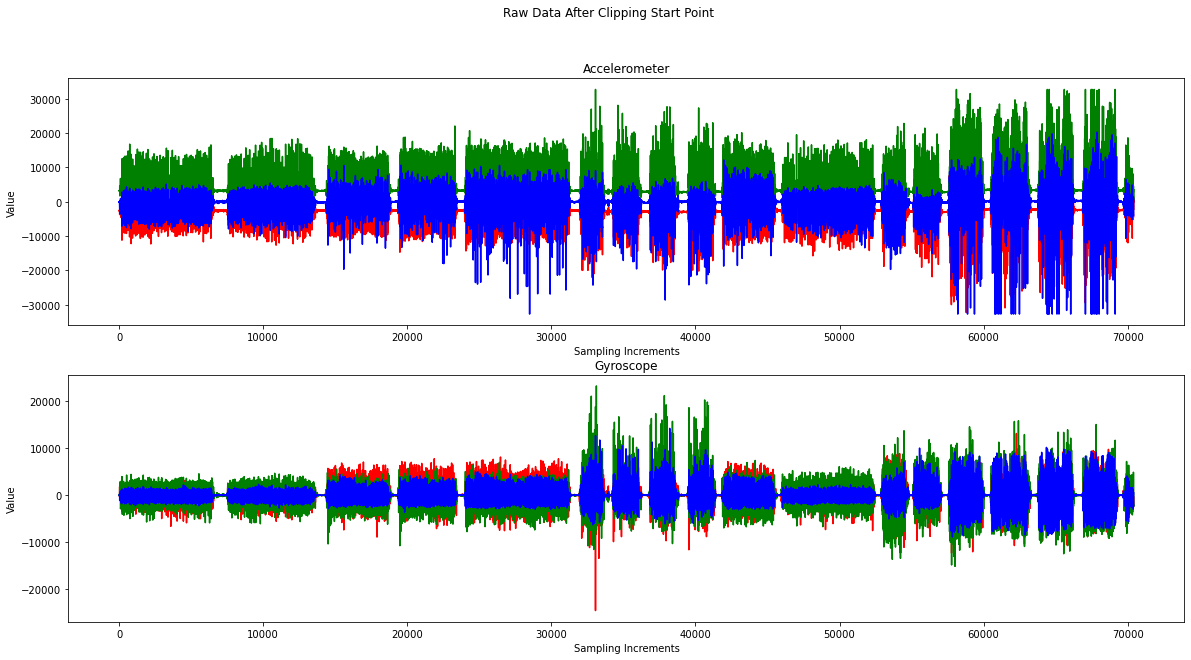

In [9]:
start_idx = 825

fig, axs = plt.subplots(2,1,figsize=(20,10))
fig.suptitle("Raw Data After Clipping Start Point")
axs[0].plot(ax_set[start_idx:370000], color='r')
axs[0].plot(ay_set[start_idx:370000], color='g')
axs[0].plot(az_set[start_idx:370000], color='b')
axs[0].set_title("Accelerometer")
axs[0].set_xlabel("Sampling Increments")
axs[0].set_ylabel("Value")

axs[1].plot(gx_set[start_idx:370000], color='r')
axs[1].plot(gy_set[start_idx:370000], color='g')
axs[1].plot(gz_set[start_idx:370000], color='b')
axs[1].set_title("Gyroscope")
axs[1].set_xlabel("Sampling Increments")
axs[1].set_ylabel("Value")

## Find the end point of the video and cut the unnecessary end noise

1598240221.0


Text(0, 0.5, 'Value')

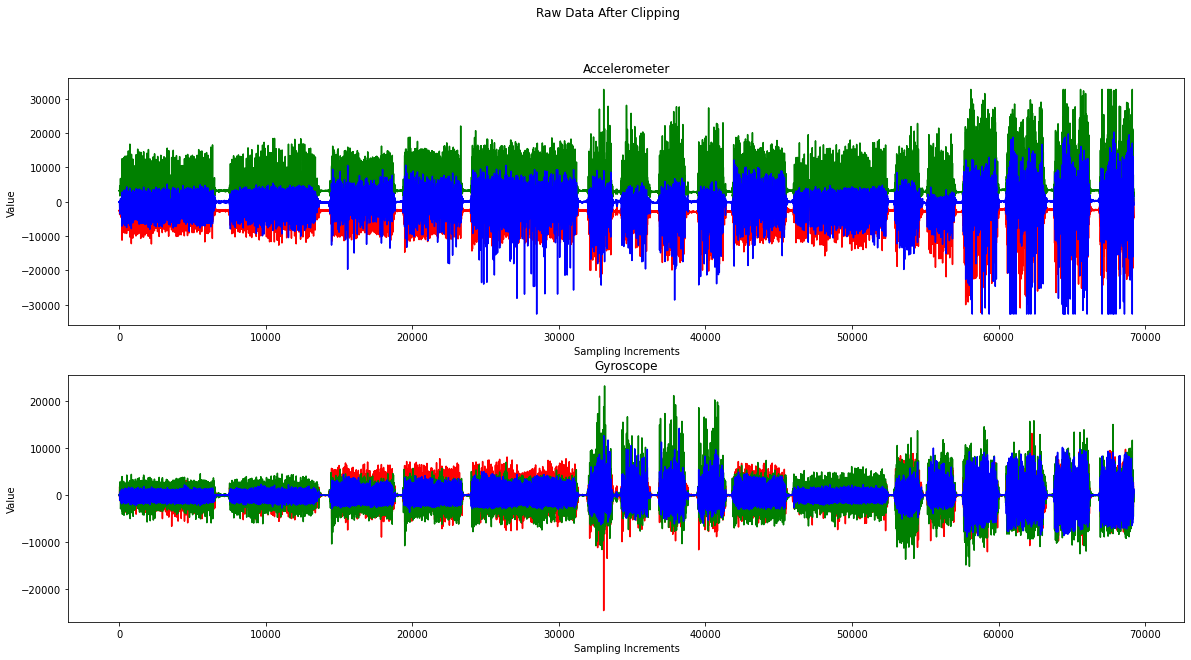

In [10]:
#Now we need to find the end point
start_ts = time_track[start_idx]
print(start_ts)

# The video has been cut to 443 seconds in length - need to find 
# Start_ts + 443 seconds. This should land us at the end point
# We can sanity check this by inspecting the plot

end_idx = time_track.index(start_ts+711)

# Sanity Check
fig, axs = plt.subplots(2,1,figsize=(20,10))
fig.suptitle("Raw Data After Clipping")
axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')
axs[0].set_title("Accelerometer")
axs[0].set_xlabel("Sampling Increments")
axs[0].set_ylabel("Value")

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')
axs[1].set_title("Gyroscope")
axs[1].set_xlabel("Sampling Increments")
axs[1].set_ylabel("Value")

## Read in the annotations file data as CSV, iterate through the data and separate to get the time stamp

In [11]:
with open(annotations_path, newline='') as f:
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for row in reader:
        time_Stamp = (row[0].split('='))[1]
        activity_set.append([float(time_Stamp),row[-1], map_activity(row[-1])])

## Cut the data from the activity set, and find the vertical line of best fit to separate the points

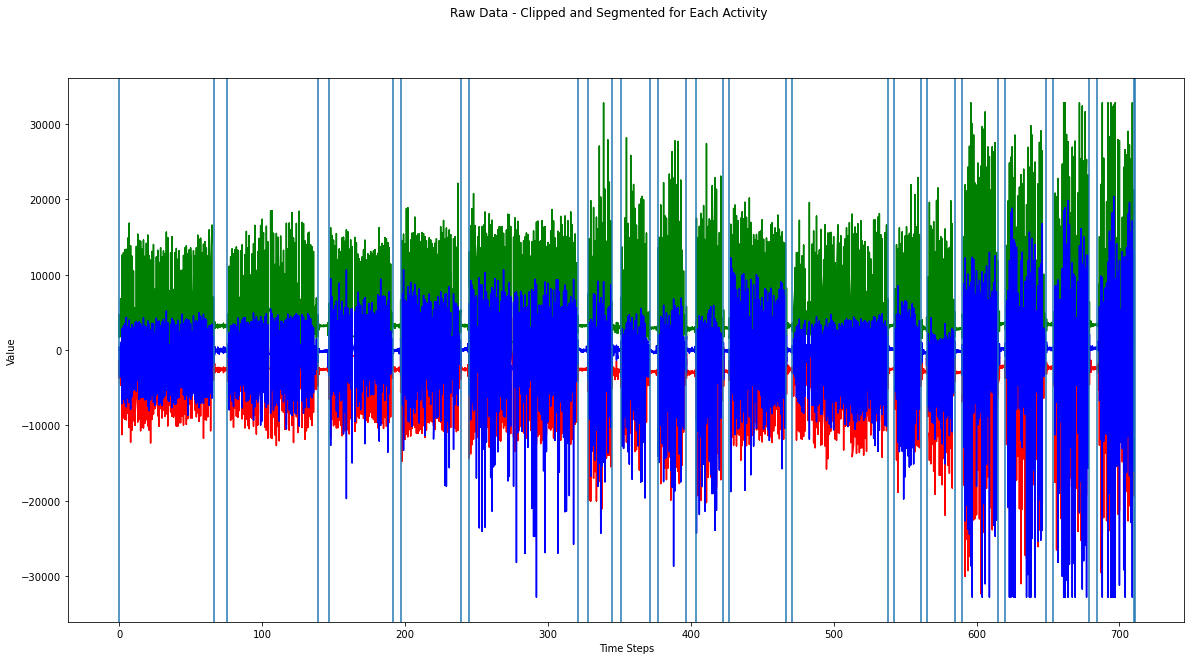

In [12]:
# Now we can create an activity time track for each data point within
# the imu timeseries. We will have a list to store the numeric code and the string.
activity_timeseries = []
activity_string_timeseries = []
activity_idx = 0

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

#Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time

fig, ax = plt.subplots(figsize=(20,10))
fig.suptitle("Raw Data - Clipped and Segmented for Each Activity")
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')
ax.set_xlabel("Time Steps")
ax.set_ylabel("Value")

for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act))

## Plot the end time steps to check the data

In [13]:
for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        #Move to nex activity
        activity_idx = activity_idx + 1
        next_activity_ts = activity_set[activity_idx+1][0]
    
    
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])

## Plot a histogram to visualise the distribution

C:\Users\wills\AppData\Local\Temp\ipykernel_5332\1897172490.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "Standing", "Walking", "Jogging", "Side-Step", "Running"])


[Text(-1.0, 0, ''),
 Text(0.0, 0, 'Standing'),
 Text(1.0, 0, 'Walking'),
 Text(2.0, 0, 'Jogging'),
 Text(3.0, 0, 'Side-Step'),
 Text(4.0, 0, 'Running'),
 Text(5.0, 0, '')]

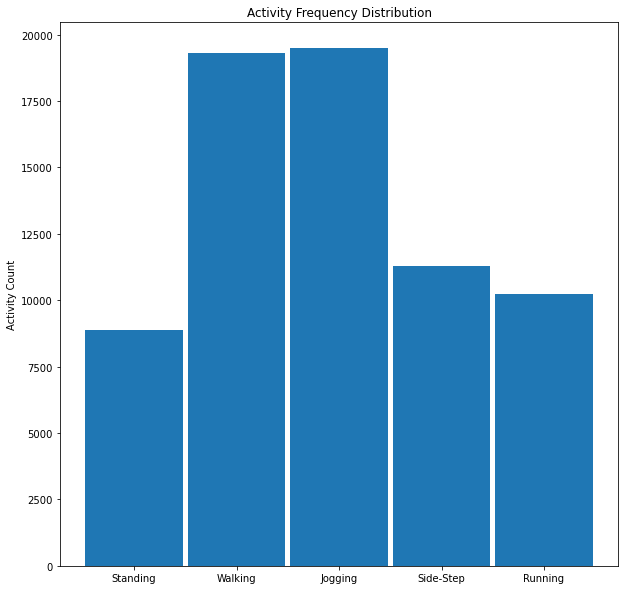

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(activity_timeseries,bins=[-0.5,0.5,1.5,2.5,3.5,4.5], rwidth=0.95)
ax.set_title("Activity Frequency Distribution")
ax.set_ylabel("Activity Count")
ax.set_xticklabels(["", "Standing", "Walking", "Jogging", "Side-Step", "Running"])

## Set the x, y, z sets to the range of start to finish data

In [15]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

## Calculate the Signal Magnitude Area, and the Average Intensity for each label.
## Store the data into features, a target set for the training and testing data based on a 1 second interval from the video window

## The Signal Magnitude Area:  SMA=1T(T∑t=1|ax(t)|+T∑t=1|ay(t)|+(T∑t=1|az(t)|)

## Average intensity: 

## AI=1T(T∑t=1(√ax(t)2+ay(t)2+ay(t)2)

In [16]:
feature_set = []
target_set  = []            
window_size = 1.0

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    if not t+window_size in time_track_segment or not t in time_track_segment:
        continue

    #The index function finds the index of the first occurrence of the data
    window_start_idx = list(time_track_segment).index(t)
    window_end_idx = list(time_track_segment).index(t+window_size)
    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]
    
    # Now we can build features from the data window
    # Mean
    mu_ax, mu_ay, mu_az = statistics.mean(ax_window), statistics.mean(ay_window), statistics.mean(az_window)
    mu_gx, mu_gy, mu_gz = statistics.mean(gx_window), statistics.mean(gy_window), statistics.mean(gz_window)

    # Max
    max_ax, max_ay, max_az = max(ax_window), max(ay_window), max(az_window)
    max_gx, max_gy, max_gz = max(gx_window), max(gy_window), max(gz_window)

    # Min
    min_ax, min_ay, min_az = min(ax_window), min(ay_window), min(az_window)
    min_gx, min_gy, min_gz = min(gx_window), min(gy_window), min(gz_window)

    # Sum
    ax_abs_sum, ay_abs_sum, az_abs_sum = 0, 0, 0
    gx_abs_sum, gy_abs_sum, gz_abs_sum = 0, 0, 0

    # Sum of sqrt
    a_sum_sq = 0
    g_sum_sq = 0

    for i in range(0, len(ax_window)):

        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])

        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])

        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq

    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)

    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz,
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz,
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz,
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)

## Visualise the data

Text(0, 0.5, 'Value')

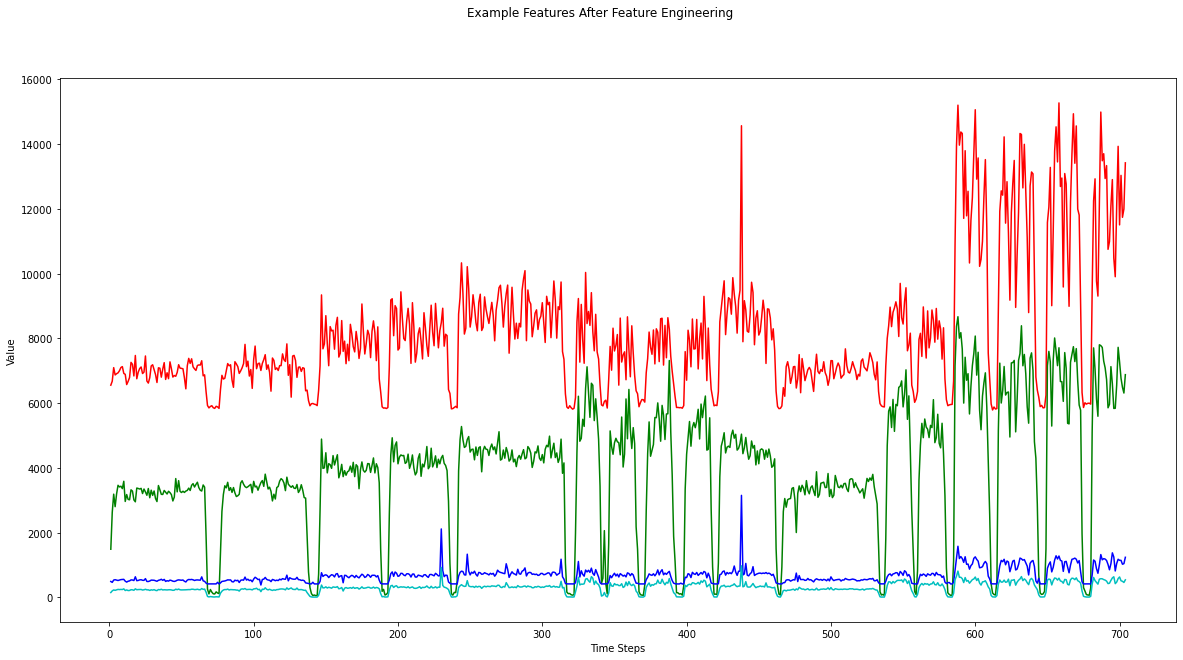

In [17]:
# Visualise some features, SMA and AI

fig, ax = plt.subplots(figsize=(20,10))
fig.suptitle("Example Features After Feature Engineering")
ax.plot(range(1,705),np.array(feature_set)[:,18], color='r')
ax.plot(range(1,705),np.array(feature_set)[:,19], color='g')
ax.plot(range(1,705),np.array(feature_set)[:,20], color='b')
ax.plot(range(1,705),np.array(feature_set)[:,21], color='c')
ax.set_xlabel("Time Steps")
ax.set_ylabel("Value")

# *** Helper functions ***

## Create a re-usable function to plot ROC Curves for each of the classifiers

In [18]:
def plot_roc_curve(function=None):
        nclasses = 5
        classifier = function
        x_train, x_test, y_train, y_test = train_test_split(feature_set, target_set, test_size=.2)
        classifier.fit(x_test, y_test)
        y_score = classifier.predict_proba(x_test)
        y_test_bin = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4])
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(nclasses):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        fig, ax = plt.subplots(figsize=(5, 5))
        colors = ['cyan', 'magenta', 'purple', 'blue', 'pink']
        plt.plot([0,1], [0,1], "r--")
        for i, color in zip(range(nclasses), colors):
            plt.plot(fpr[i], tpr[i], color=color,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                           ''.format(i, roc_auc[i]))
        ax.set_xlabel("False Positives")
        ax.set_ylabel("True Positives")
        ax.set_title("ROC Curve of Classifications")
        ax.legend(["y=x", "Walking", "Standing", "Running", "Side-Step", "Jogging"])
        plt.show()
        return None

## Create a function to find the best test and train split for the data

In [19]:
classifiers = ["Standing", "Walking", "Jogging", "Side-Step", "Running"]

c_names = [[i] for i in classifiers]

# Feature names for the tree.
labels = ["Mean Ax", "Mean Ay", "Mean Az","Mean Gx", "Mean Gy", "Mean Gz",
           "Max Ax", "Max Ay", "Max Az","Max Gx", "Max Gy", "Max Gz", 
           "Min Ax", "Min Ay", "Min Az","Min Gx", "Min Gy", "Min Gz",
           "Acceleration SMA", "Gyroscope SMA" , "Acceleration AI", "Gyroscope AI"]

f_names = [[i] for i in labels]

def get_training_split():
    test_sizes = [round(float(i * .1), 2) for i in range(1, 9)].__reversed__()
    test_sizes = list(test_sizes)
    knn = neighbors.KNeighborsClassifier(n_neighbors=4)
    plt.figure()

    for test_size in test_sizes:
        scores = []
        for i in range(1, 100):
            x_train, x_test, y_train, y_test = train_test_split(feature_set, target_set, test_size=1 - test_size)
            knn.fit(x_train, y_train)
            scores.append(knn.score(x_test, y_test))
        plt.plot(test_size, np.mean(scores), "r+")
    plt.plot()
    plt.xlabel("training % split")
    plt.ylabel("predictions")
    plt.show()
    return None

# *** KNN Classifier ***

Contributor: Will Duckworth

## Create a function to find the best neighbors for the KNN Classifier

In [20]:
def find_knn_neighbours():
    k_range = range(1,20)
    scores = []
    max_score = []
    for k in k_range:
        x_train, x_test, y_train, y_test = train_test_split(feature_set, target_set)
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        scores.append(knn.score(x_test, y_test))
        max_score.append([(knn.score(x_test, y_test)), k]) 
    plt.figure()
    plt.xlabel("k neighbours")
    plt.ylabel("predictions")
    plt.scatter(k_range, scores)
    plt.grid()
    plt.xticks([i for i in range(0, 35, 5)])
    plt.xlim([0, 30])
    plt.ylim([0, 1])
    plt.show()
    max_score = max(max_score[1])
    return max_score

## Train and test the data based on the KNN Classifier and produce plots to visually inspect the performance

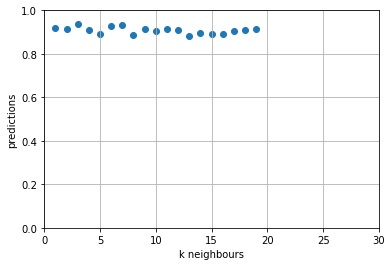

CV Train Recall:	 [0.95833333 0.95364238 0.96226415 0.84444444 0.76923077]
CV Train Precision:	 [0.80232558 0.90566038 0.90532544 0.96202532 1.        ]
CV Train F1 Score:	 [0.87341772 0.92903226 0.93292683 0.89940828 0.86956522]
Test Recall:		 [0.89473684 0.95555556 0.9        0.95833333 1.        ]
Test Precision:		 [0.77272727 0.91489362 1.         1.         1.        ]
Test F1 Score:		 [0.82926829 0.93478261 0.94736842 0.9787234  1.        ]


C:\Users\wills\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\wills\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


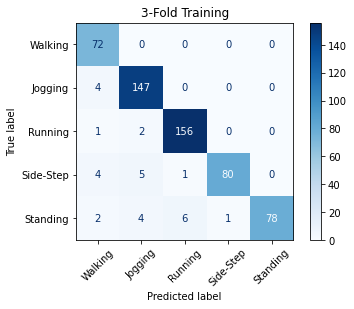

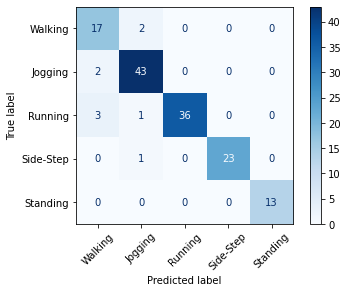

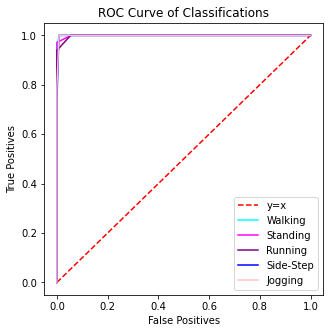

In [21]:
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, test_size=.2, random_state=42)

# Set the number neighbours to use in the classifier
n_neighbors = find_knn_neighbours()

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')

# Train the model
clf.fit(X_train, y_train)

# Return the predictions for the 3-Fold cross-validation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)

# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)

# Construct the confusion matrices
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# store categorical accuracy for comparison to other models
knn_cat_accuracy = list(conf_mat_test.diagonal()/conf_mat_test.sum(axis=1))

# Print out the recall, precision and F1 scores
# There will be a value for each class
# CV Train
print("CV Train Recall:\t", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:\t",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:\t",f1_score(y_train,y_predicted,average=None))

# Test
print("Test Recall:\t\t",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:\t\t",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:\t\t",f1_score(y_test,y_test_predicted,average=None))

# Plot the confusion matrices
fig, ax = plt.subplots()
disp = plot_cm(clf, X_train, y_train,
                                 display_labels=['Walking','Jogging','Running', 'Side-Step', 'Standing'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('3-Fold Training')

fig, ax = plt.subplots()
disp = plot_cm(clf, X_test, y_test,
                                 display_labels=['Walking', 'Jogging', 'Running', 'Side-Step', 'Standing'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
plot_roc_curve(clf)

## Create a function to get the best training split for the RandomForestClassifier

<IPython.core.display.Javascript object>


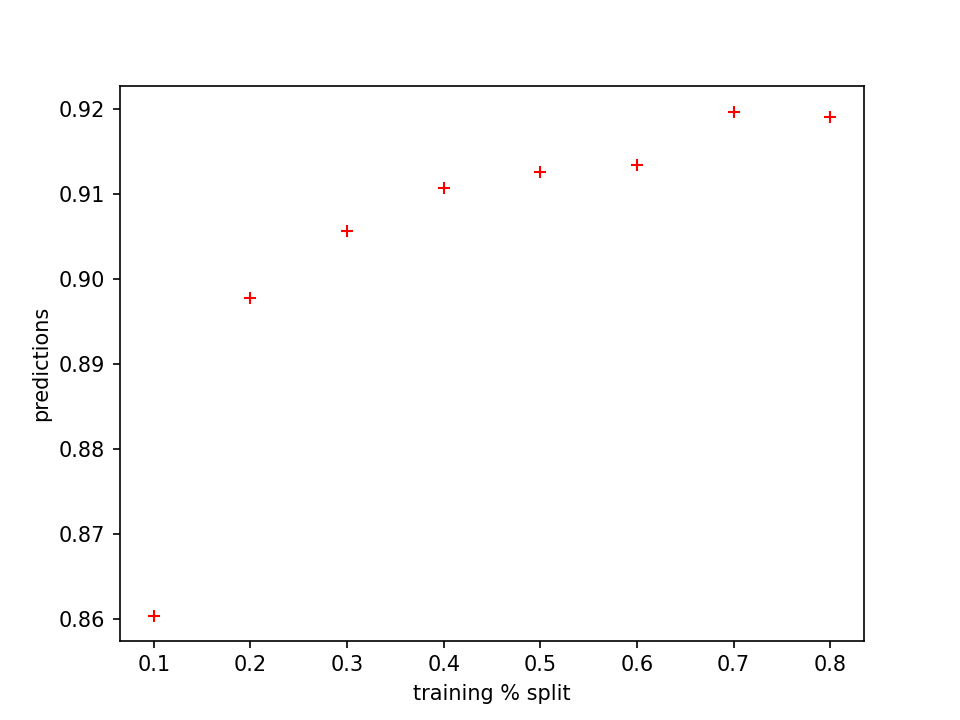

In [22]:
def get_training_split_forrest():
    test_sizes = [round(float(i * .1), 2) for i in range(1, 9)].__reversed__()
    test_sizes = list(test_sizes)
    clf = RandomForestClassifier()
    plt.figure()

    for test_size in test_sizes:
        scores = []
        for i in range(1, 100):
            x_train, x_test, y_train, y_test = train_test_split(feature_set, target_set, test_size=1 - test_size)
            clf.fit(x_train, y_train)
            scores.append(clf.score(x_test, y_test))
        plt.plot(test_size, np.mean(scores), "r+")
    plt.plot()
    plt.xlabel("training % split")
    plt.ylabel("predictions")
    plt.show()
    return None

%matplotlib notebook
get_training_split()

# *** Random Forest Classifier ***

Contributor: Will Duckworth

## Test and train the Random Forest Classifier and plot graphs to visualise the data

CV Train Recall:	 [0.93055556 0.97350993 0.97484277 0.92222222 0.91208791]
CV Train Precision:	 [0.88157895 0.90184049 0.98726115 0.98809524 1.        ]
CV Train F1 Score:	 [0.90540541 0.93630573 0.98101266 0.95402299 0.95402299]
Test Recall:		 [0.89473684 0.97777778 0.925      0.95833333 1.        ]
Test Precision:		 [0.89473684 0.91666667 1.         1.         0.92857143]
Test F1 Score:		 [0.89473684 0.94623656 0.96103896 0.9787234  0.96296296]


<IPython.core.display.Javascript object>


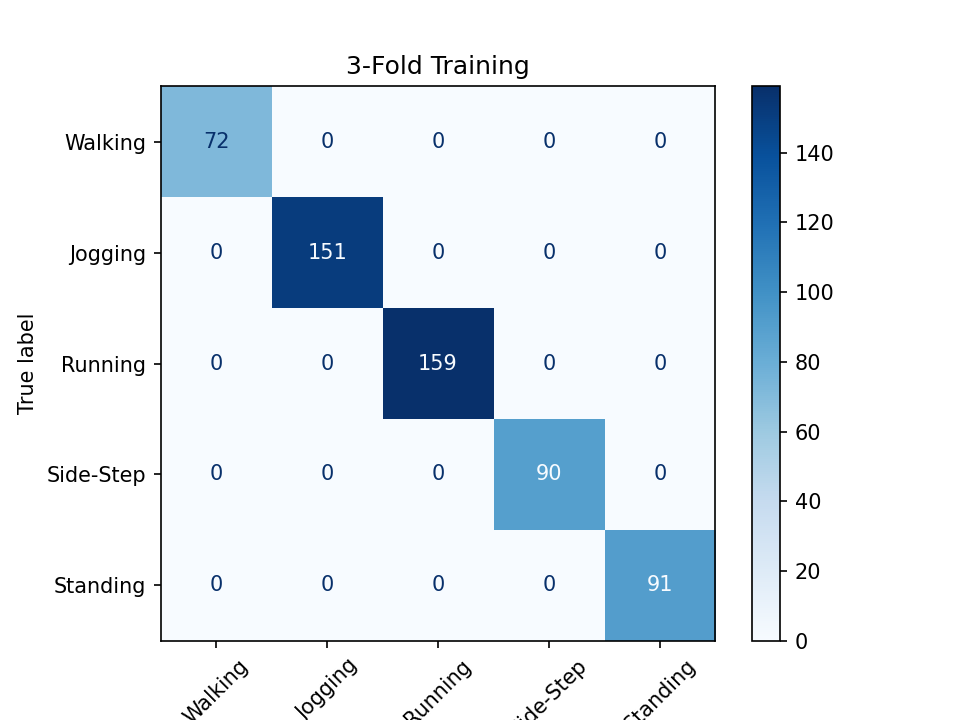

C:\Users\wills\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


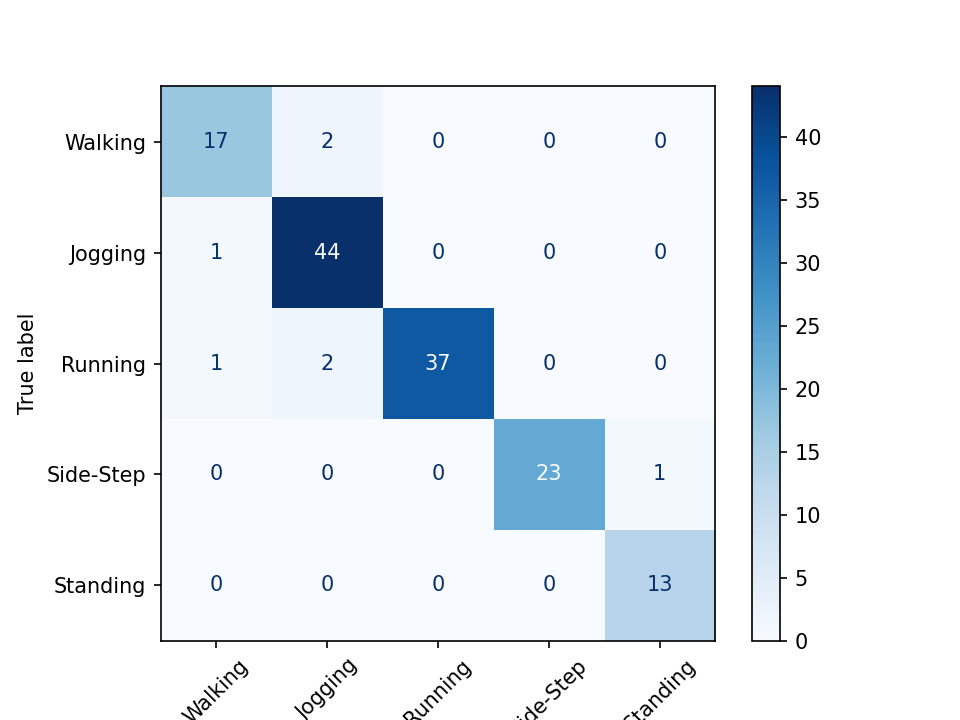

C:\Users\wills\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, test_size=.2, random_state=42)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)
# Return the predictions for the 3-Fold cross-validation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)
# Construct the confusion matrices
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# store categorical accuracy for comparison to other models
rf_cat_accuracy = list(conf_mat_test.diagonal()/conf_mat_test.sum(axis=1))

# Print out the recall, precision and F1 scores
# There will be a value for each class
# CV Train
print("CV Train Recall:\t", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:\t",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:\t",f1_score(y_train,y_predicted,average=None))

# Test
print("Test Recall:\t\t",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:\t\t",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:\t\t",f1_score(y_test,y_test_predicted,average=None))

# Plot the confusion matrices using the pretty functions
fig, ax = plt.subplots()
disp = plot_cm(clf, X_train, y_train,
                                 display_labels=['Walking','Jogging','Running', 'Side-Step', 'Standing'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('3-Fold Training')

fig, ax = plt.subplots()
disp = plot_cm(clf, X_test, y_test,
                                 display_labels=['Walking', 'Jogging', 'Running', 'Side-Step', 'Standing'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# *** Stochastic Gradient Descent Classifier ***

Contributor: Jim Purvis

## Split and scale data

In [24]:
# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, random_state=42)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train model and optimise hyper parameters through iteration

In [25]:
from sklearn.metrics import recall_score, precision_score

best_mean_f1 = 0
best_alpha = 0
best_max_iter = 0

alpha_test_values = [0.001,0.005,0.01,0.05]
max_iter_test_values = [100,250,500]

# Iterate through hyper parameter options
for alpha in alpha_test_values:
    for iterations in max_iter_test_values:

        # train classifier
        sgd = SGDClassifier(alpha=alpha, max_iter=iterations, random_state=42)
        sgd.fit(X_train_scaled, y_train)

        # predict using 3-fold cross validation
        y_train_predicted = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)                # TODO: DO I NEED TO SPECIFY FEATURE COLUMNS HERE ??


        current_f1 = np.mean(f1_score(y_train, y_train_predicted, average=None))
        if current_f1 > best_mean_f1:
            best_mean_f1 = current_f1
            best_alpha = alpha
            best_max_iter = iterations
            best_sgd = sgd
            best_y_train_predicted = y_train_predicted


# predict using best SGD classifier
y_test_predicted = best_sgd.predict(X_test_scaled)

print("Hyper Parameter Combination")
print("Best alpha: ", best_alpha)
print("Best max_iter: ", best_max_iter, "\n")
print("CV Train Recall: \t\t", recall_score(y_train, best_y_train_predicted, average=None))
print("CV Train Precision: \t", precision_score(y_train, best_y_train_predicted, average=None))
print("CV Train F1: \t\t\t", f1_score(y_train, best_y_train_predicted, average=None))
print("Test Recall: \t\t\t", recall_score(y_test, y_test_predicted, average=None))
print("Test Precision: \t\t", precision_score(y_test, y_test_predicted, average=None))
print("Test F1: \t\t\t\t", f1_score(y_test, y_test_predicted, average=None))

Hyper Parameter Combination
Best alpha:  0.01
Best max_iter:  100 

CV Train Recall: 		 [0.92647059 0.95       0.98648649 0.90588235 0.88505747]
CV Train Precision: 	 [0.92647059 0.9109589  0.94805195 0.95061728 0.97468354]
CV Train F1: 			 [0.92647059 0.93006993 0.96688742 0.92771084 0.92771084]
Test Recall: 			 [0.91304348 0.94642857 0.96078431 0.89655172 1.        ]
Test Precision: 		 [0.91304348 0.92982456 0.94230769 1.         0.94444444]
Test F1: 				 [0.91304348 0.9380531  0.95145631 0.94545455 0.97142857]


## Plot Confusion Matrices

<IPython.core.display.Javascript object>


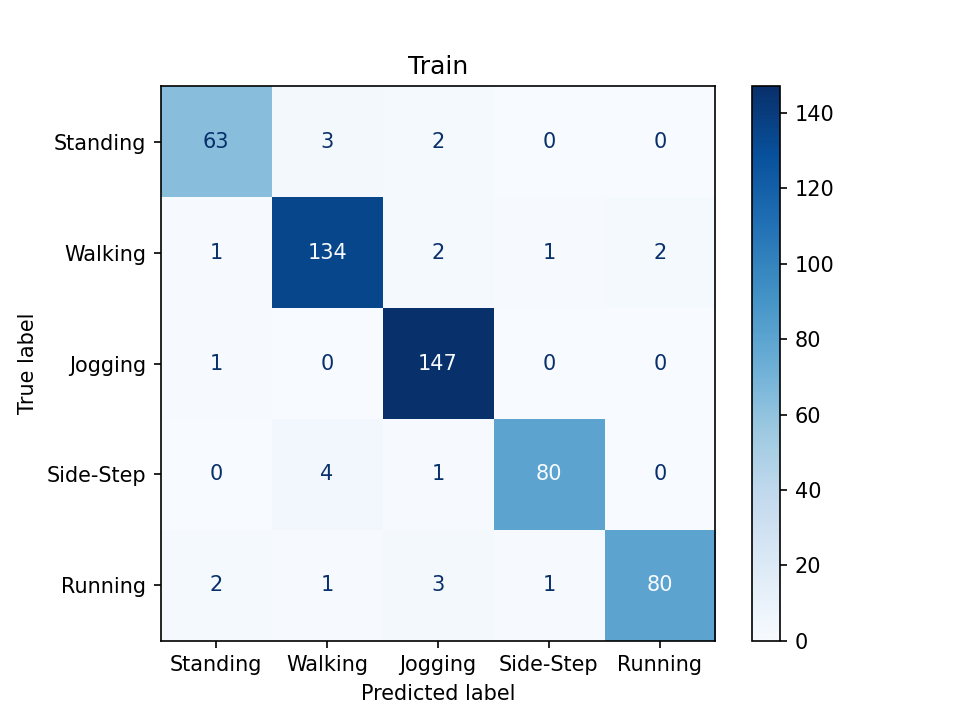

C:\Users\wills\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


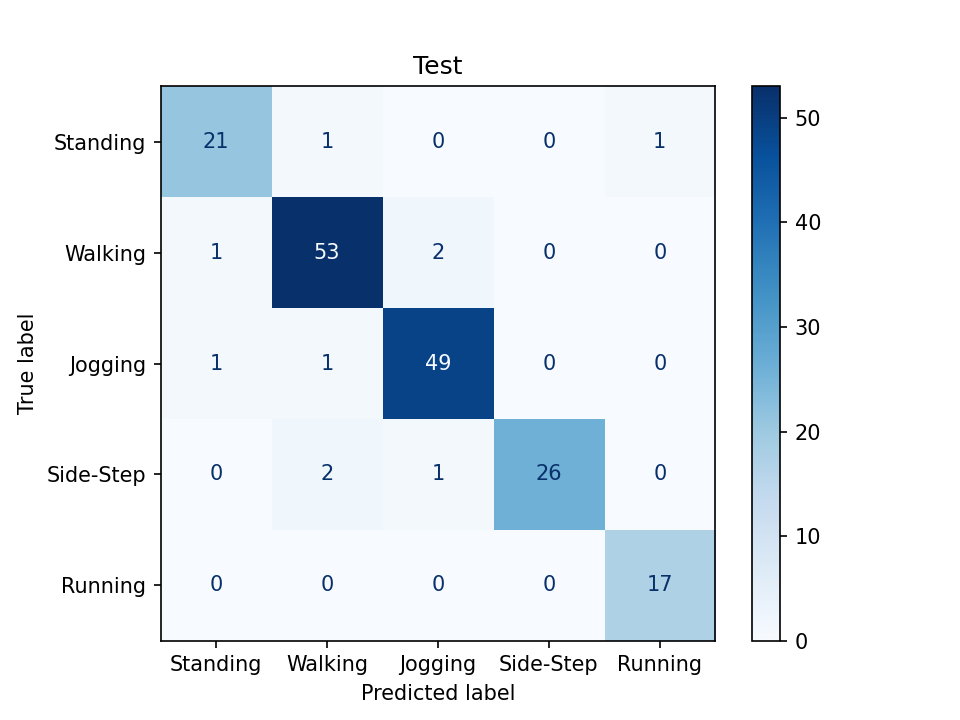

C:\Users\wills\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [26]:
# plot confusion matrix for train set
fig, ax = plt.subplots()
ax.set_title("Train")
disp = plot_cm(best_sgd, X_train_scaled, y_train,
                             display_labels=["Standing", "Walking", "Jogging", "Side-Step", "Running"],
                             cmap=plt.cm.Blues, ax=ax)

# plot confusion matrix for test set
fig, ax = plt.subplots()
ax.set_title("Test")
disp = plot_cm(best_sgd, X_test_scaled, y_test,
                             display_labels=["Standing", "Walking", "Jogging", "Side-Step", "Running"],
                             cmap=plt.cm.Blues, ax=ax)

# Store categorical accuracy for comparison to other models
conf_mat_test = confusion_matrix(y_test, y_test_predicted)
sgd_cat_accuracy = list(conf_mat_test.diagonal()/conf_mat_test.sum(axis=1))

# *** Neural Network ***

Contributor: Jim Purvis

## Split and scale data

In [27]:
# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, random_state=42)

# convert to numpy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert target classes to categorical array for neural network
y_train_cat_array = to_categorical(y_train, num_classes=5)
y_test_cat_array = to_categorical(y_test, num_classes=5)

## Build and train NN model

In [28]:
# NN input layer size
input_size = len(X_test_scaled[0])
# set random state
tf.random.set_seed(42)
# declare variable for activation function to test various functions
activation_function = 'relu'

# build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_size, activation=activation_function),
    tf.keras.layers.Dense(128, activation=activation_function),
    tf.keras.layers.Dropout(rate=0.25, seed=42),
    tf.keras.layers.Dense(128, activation=activation_function),
    tf.keras.layers.Dropout(rate=0.25, seed=42),
    tf.keras.layers.Dense(128, activation=activation_function),
    tf.keras.layers.Dropout(rate=0.25, seed=42),
    tf.keras.layers.Dense(64, activation=activation_function),
    tf.keras.layers.Dropout(rate=0.25, seed=42),
    tf.keras.layers.Dense(32, activation=activation_function),
    tf.keras.layers.Dense(5, activation='softmax')
])

# compile model
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['categorical_accuracy']
)

# train model
history = model.fit(
    X_train_scaled,
    y_train_cat_array,
    epochs=250,
    validation_data=(X_test_scaled, y_test_cat_array),      # Ideally a validation split would be used here, but for our example the test data has been used for validation
    batch_size=32
)

Epoch 1/250
17/17 [==============================] - 1s 17ms/step - loss: 1.6404 - categorical_accuracy: 0.1610 - val_loss: 1.6219 - val_categorical_accuracy: 0.1648
Epoch 2/250
17/17 [==============================] - 0s 4ms/step - loss: 1.6171 - categorical_accuracy: 0.2178 - val_loss: 1.6042 - val_categorical_accuracy: 0.3125
Epoch 3/250
17/17 [==============================] - 0s 4ms/step - loss: 1.6094 - categorical_accuracy: 0.1837 - val_loss: 1.5898 - val_categorical_accuracy: 0.2898
Epoch 4/250
17/17 [==============================] - 0s 4ms/step - loss: 1.5957 - categorical_accuracy: 0.2538 - val_loss: 1.5765 - val_categorical_accuracy: 0.2898
Epoch 5/250
17/17 [==============================] - 0s 4ms/step - loss: 1.5913 - categorical_accuracy: 0.2803 - val_loss: 1.5654 - val_categorical_accuracy: 0.2898
Epoch 6/250
17/17 [==============================] - 0s 4ms/step - loss: 1.5813 - categorical_accuracy: 0.2784 - val_loss: 1.5569 - val_categorical_accuracy: 0.2898
Epoch 7/2

17/17 [==============================] - 0s 4ms/step - loss: 0.5025 - categorical_accuracy: 0.8409 - val_loss: 0.2955 - val_categorical_accuracy: 0.9375
Epoch 51/250
17/17 [==============================] - 0s 4ms/step - loss: 0.4923 - categorical_accuracy: 0.8769 - val_loss: 0.2772 - val_categorical_accuracy: 0.9375
Epoch 52/250
17/17 [==============================] - 0s 4ms/step - loss: 0.4651 - categorical_accuracy: 0.8750 - val_loss: 0.2671 - val_categorical_accuracy: 0.9375
Epoch 53/250
17/17 [==============================] - 0s 4ms/step - loss: 0.4097 - categorical_accuracy: 0.9053 - val_loss: 0.2581 - val_categorical_accuracy: 0.9375
Epoch 54/250
17/17 [==============================] - 0s 4ms/step - loss: 0.4280 - categorical_accuracy: 0.9034 - val_loss: 0.2635 - val_categorical_accuracy: 0.9432
Epoch 55/250
17/17 [==============================] - 0s 4ms/step - loss: 0.4399 - categorical_accuracy: 0.8826 - val_loss: 0.2533 - val_categorical_accuracy: 0.9432
Epoch 56/250
17/1

17/17 [==============================] - 0s 4ms/step - loss: 0.2567 - categorical_accuracy: 0.9375 - val_loss: 0.1842 - val_categorical_accuracy: 0.9602
Epoch 100/250
17/17 [==============================] - 0s 4ms/step - loss: 0.2371 - categorical_accuracy: 0.9337 - val_loss: 0.1810 - val_categorical_accuracy: 0.9602
Epoch 101/250
17/17 [==============================] - 0s 4ms/step - loss: 0.2562 - categorical_accuracy: 0.9261 - val_loss: 0.1793 - val_categorical_accuracy: 0.9602
Epoch 102/250
17/17 [==============================] - 0s 4ms/step - loss: 0.2521 - categorical_accuracy: 0.9337 - val_loss: 0.1784 - val_categorical_accuracy: 0.9602
Epoch 103/250
17/17 [==============================] - 0s 4ms/step - loss: 0.2465 - categorical_accuracy: 0.9394 - val_loss: 0.1812 - val_categorical_accuracy: 0.9602
Epoch 104/250
17/17 [==============================] - 0s 4ms/step - loss: 0.2272 - categorical_accuracy: 0.9470 - val_loss: 0.1799 - val_categorical_accuracy: 0.9602
Epoch 105/25

17/17 [==============================] - 0s 4ms/step - loss: 0.2079 - categorical_accuracy: 0.9432 - val_loss: 0.1753 - val_categorical_accuracy: 0.9602
Epoch 149/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1964 - categorical_accuracy: 0.9470 - val_loss: 0.1762 - val_categorical_accuracy: 0.9602
Epoch 150/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1980 - categorical_accuracy: 0.9394 - val_loss: 0.1765 - val_categorical_accuracy: 0.9602
Epoch 151/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1909 - categorical_accuracy: 0.9527 - val_loss: 0.1762 - val_categorical_accuracy: 0.9602
Epoch 152/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1906 - categorical_accuracy: 0.9470 - val_loss: 0.1764 - val_categorical_accuracy: 0.9602
Epoch 153/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1941 - categorical_accuracy: 0.9489 - val_loss: 0.1766 - val_categorical_accuracy: 0.9602
Epoch 154/25

17/17 [==============================] - 0s 4ms/step - loss: 0.1907 - categorical_accuracy: 0.9489 - val_loss: 0.1774 - val_categorical_accuracy: 0.9602
Epoch 198/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1514 - categorical_accuracy: 0.9564 - val_loss: 0.1773 - val_categorical_accuracy: 0.9602
Epoch 199/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1538 - categorical_accuracy: 0.9545 - val_loss: 0.1773 - val_categorical_accuracy: 0.9602
Epoch 200/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1618 - categorical_accuracy: 0.9527 - val_loss: 0.1779 - val_categorical_accuracy: 0.9602
Epoch 201/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1581 - categorical_accuracy: 0.9527 - val_loss: 0.1785 - val_categorical_accuracy: 0.9602
Epoch 202/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1719 - categorical_accuracy: 0.9545 - val_loss: 0.1798 - val_categorical_accuracy: 0.9602
Epoch 203/25

17/17 [==============================] - 0s 4ms/step - loss: 0.1521 - categorical_accuracy: 0.9545 - val_loss: 0.1730 - val_categorical_accuracy: 0.9602
Epoch 247/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1712 - categorical_accuracy: 0.9527 - val_loss: 0.1735 - val_categorical_accuracy: 0.9602
Epoch 248/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1623 - categorical_accuracy: 0.9470 - val_loss: 0.1714 - val_categorical_accuracy: 0.9602
Epoch 249/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1495 - categorical_accuracy: 0.9527 - val_loss: 0.1718 - val_categorical_accuracy: 0.9602
Epoch 250/250
17/17 [==============================] - 0s 4ms/step - loss: 0.1474 - categorical_accuracy: 0.9545 - val_loss: 0.1727 - val_categorical_accuracy: 0.9602


## Performance metrics

In [29]:
print("*****    PERFORMANCE METRICS    ***** ")
print(" MAX VAL ACCURACY: " + str(max(history.history['val_categorical_accuracy'])))
print("            EPOCH: " + str(history.history['val_categorical_accuracy'].index(max(history.history['val_categorical_accuracy'])) +1))
print("     MIN VAL LOSS: " + str(min(history.history['val_loss'])))
print("            EPOCH: " + str(history.history['val_loss'].index(min(history.history['val_loss'])) +1))

*****    PERFORMANCE METRICS    ***** 
 MAX VAL ACCURACY: 0.9602272510528564
            EPOCH: 85
     MIN VAL LOSS: 0.17055873572826385
            EPOCH: 244


## Visualise accuracy and loss curves

In [30]:
# Function to plot loss and accuracy metrics for training and validation dataset
def plot_loss_curves(history_object):
    """
    Plots loss and accuracy metrics for training and validation dataset
    """

    loss = history_object.history['loss']
    val_loss = history_object.history['val_loss']
    accuracy = history_object.history['categorical_accuracy']
    val_accuracy = history_object.history['val_categorical_accuracy']
    epochs = range(len(history_object.history['loss']))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    fig.suptitle("Loss and Accuracy Training Curves")
    fig.subplots_adjust(left=0.05)
    fig.subplots_adjust(right=0.95)

    # plot loss
    ax[0].plot(epochs, loss, label='training_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel("Loss Value")
    ax[0].legend()

    # plot accuracy
    ax[1].plot(epochs, accuracy, label='training_cat_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_cat_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel("Accuracy Score")
    ax[1].legend()
    return None

<IPython.core.display.Javascript object>


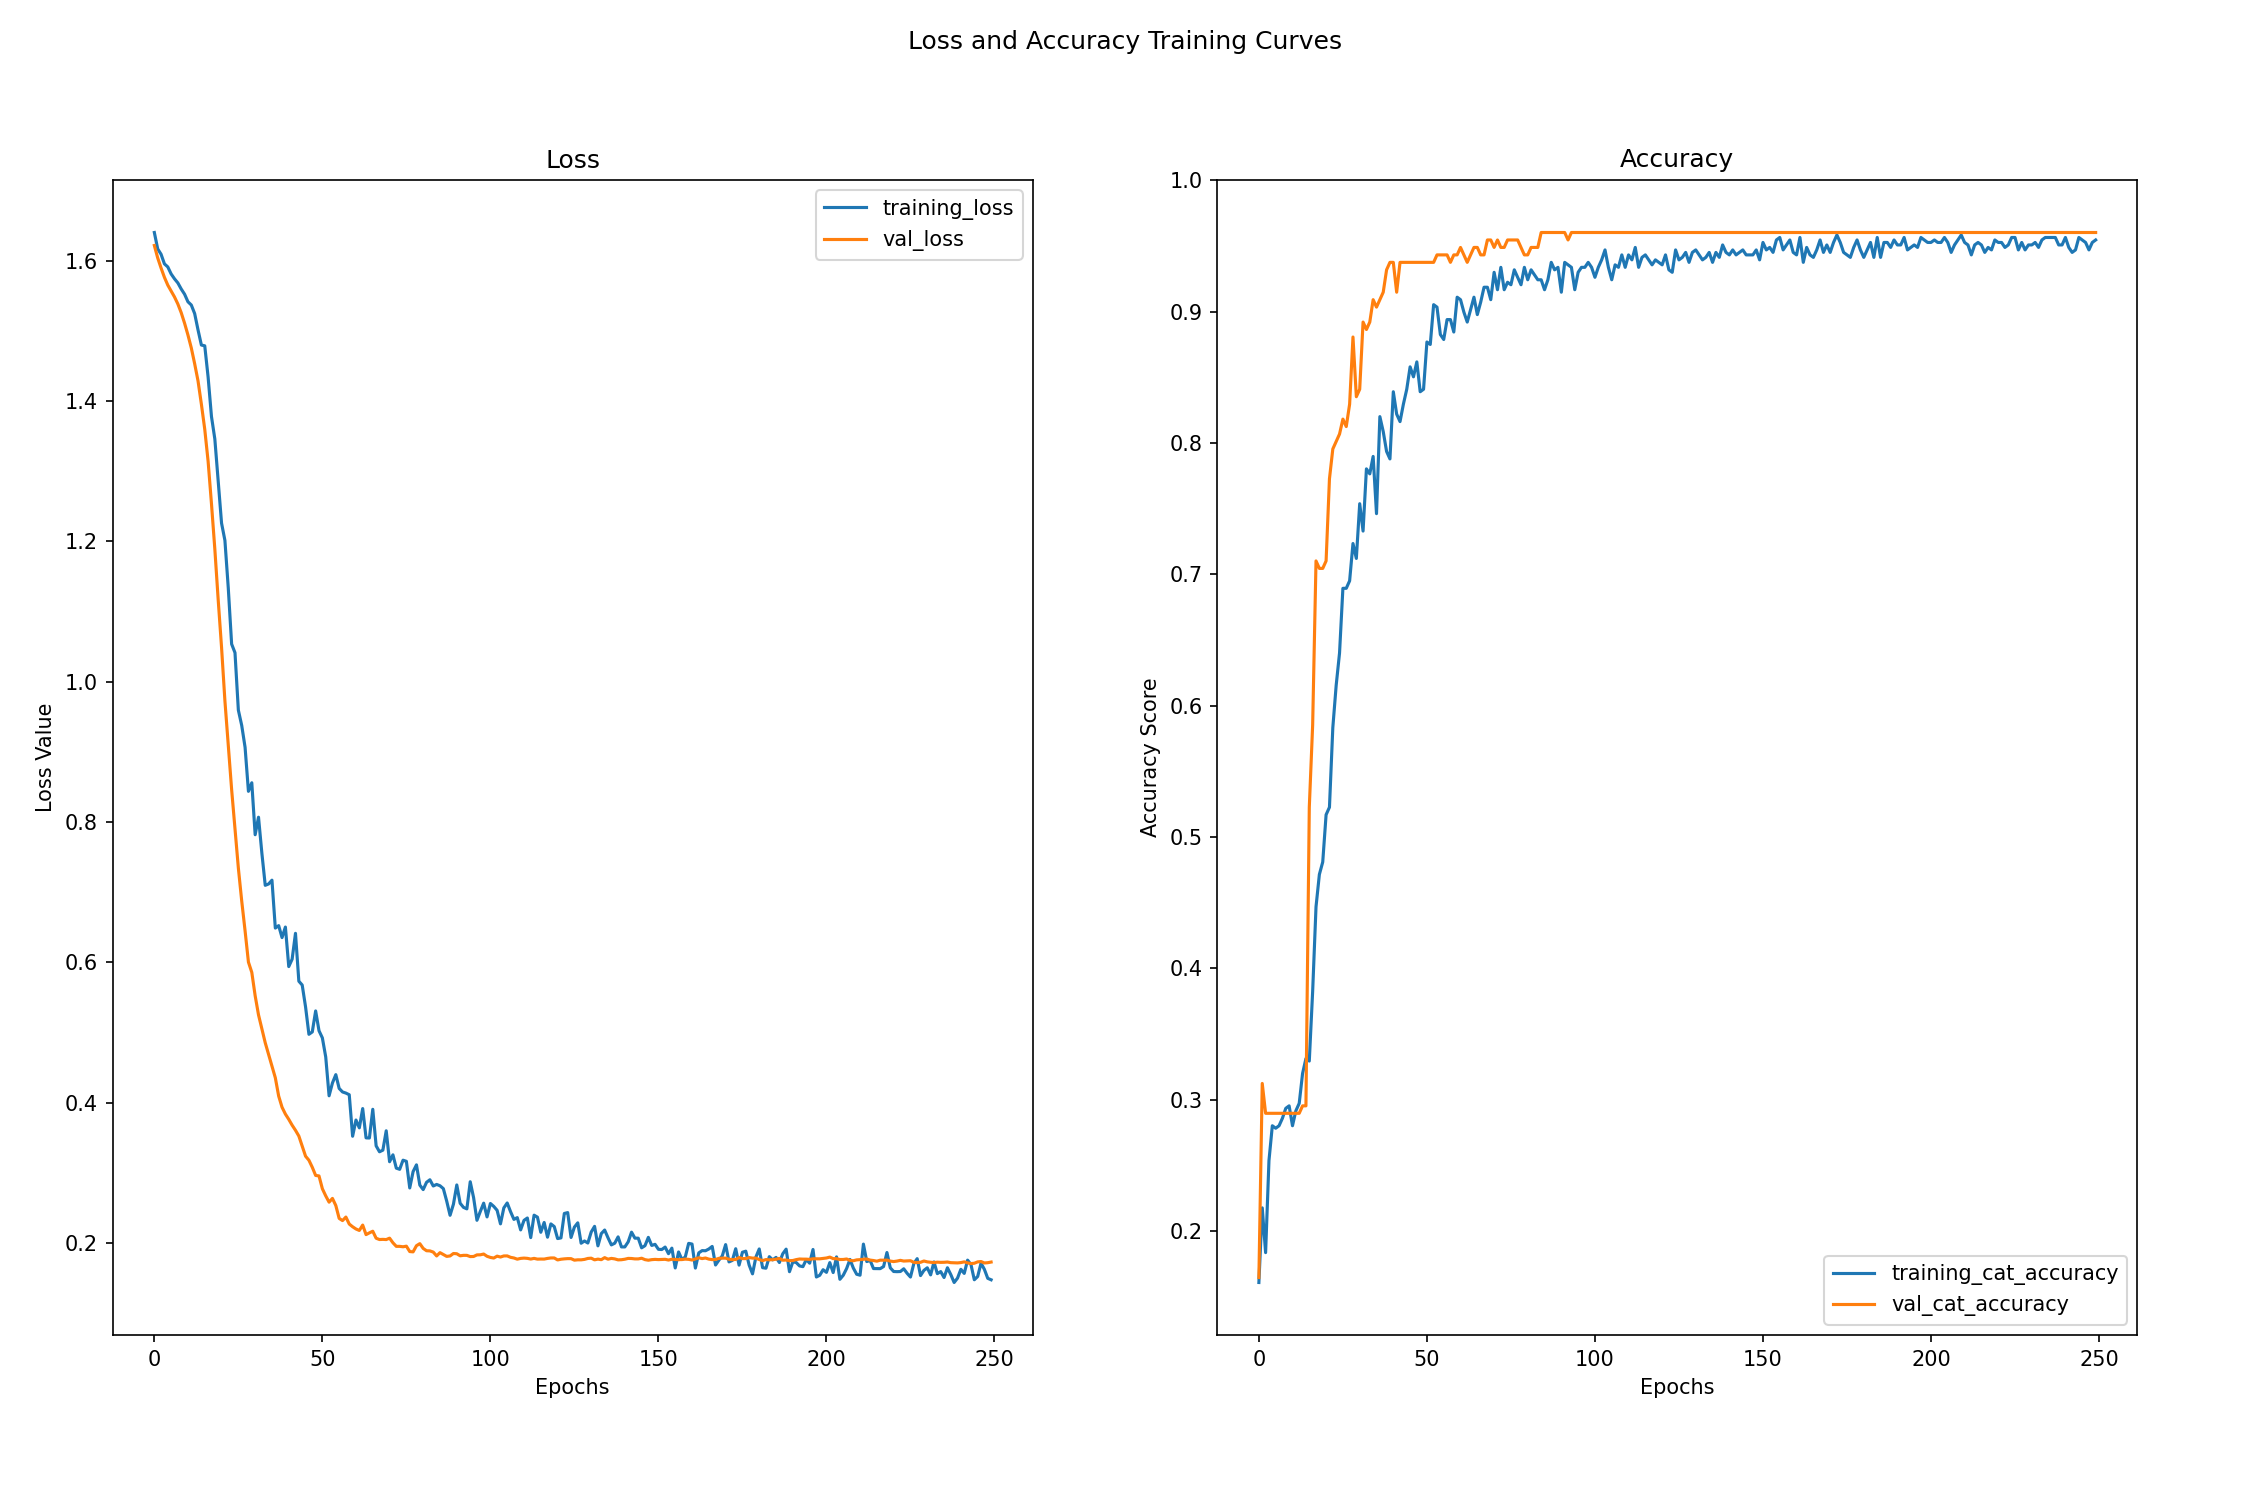

In [31]:
plot_loss_curves(history)

## Plot confusion matrix

In [32]:
# make predictions with NN model
y_predicted = model.predict(X_test_scaled)
# convert array of predicted probabilities to single column of predictions
y_predicted = np.argmax(y_predicted, axis=1)

6/6 [==============================] - 0s 1ms/step


<IPython.core.display.Javascript object>


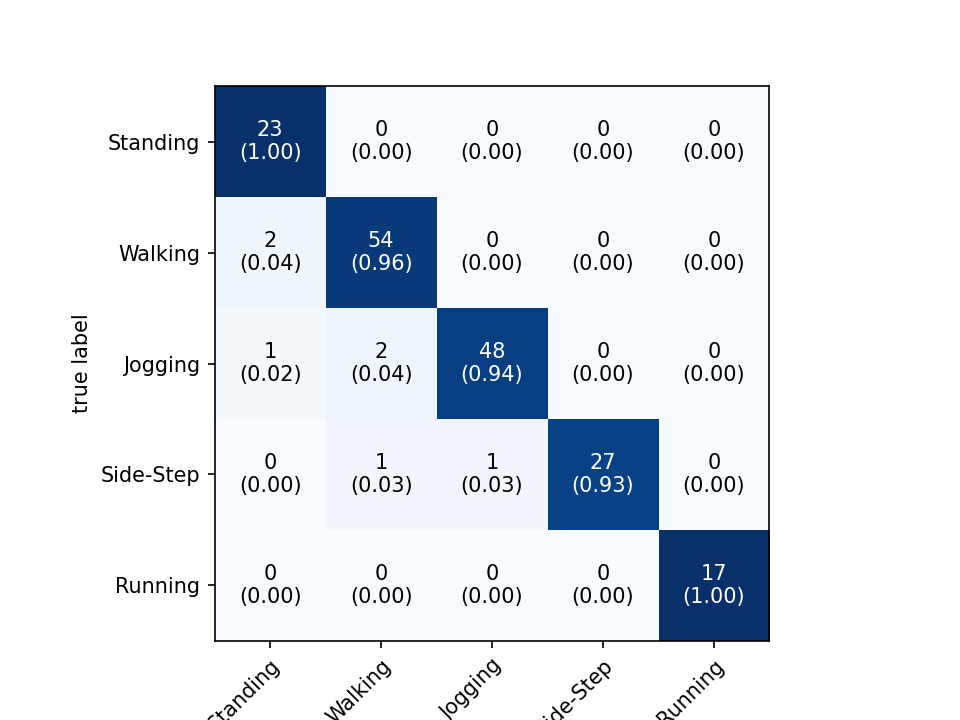

In [33]:
matrix = confusion_matrix(y_test, y_predicted)
plot_nn_cm(conf_mat=matrix, class_names=['Standing', 'Walking', 'Jogging', 'Side-Step', 'Running'], show_normed=True)
# Store categorical accuracy for comparison to other models
nn_cat_accuracy = list(matrix.diagonal()/matrix.sum(axis=1))

# Model Performance Comparison

<IPython.core.display.Javascript object>


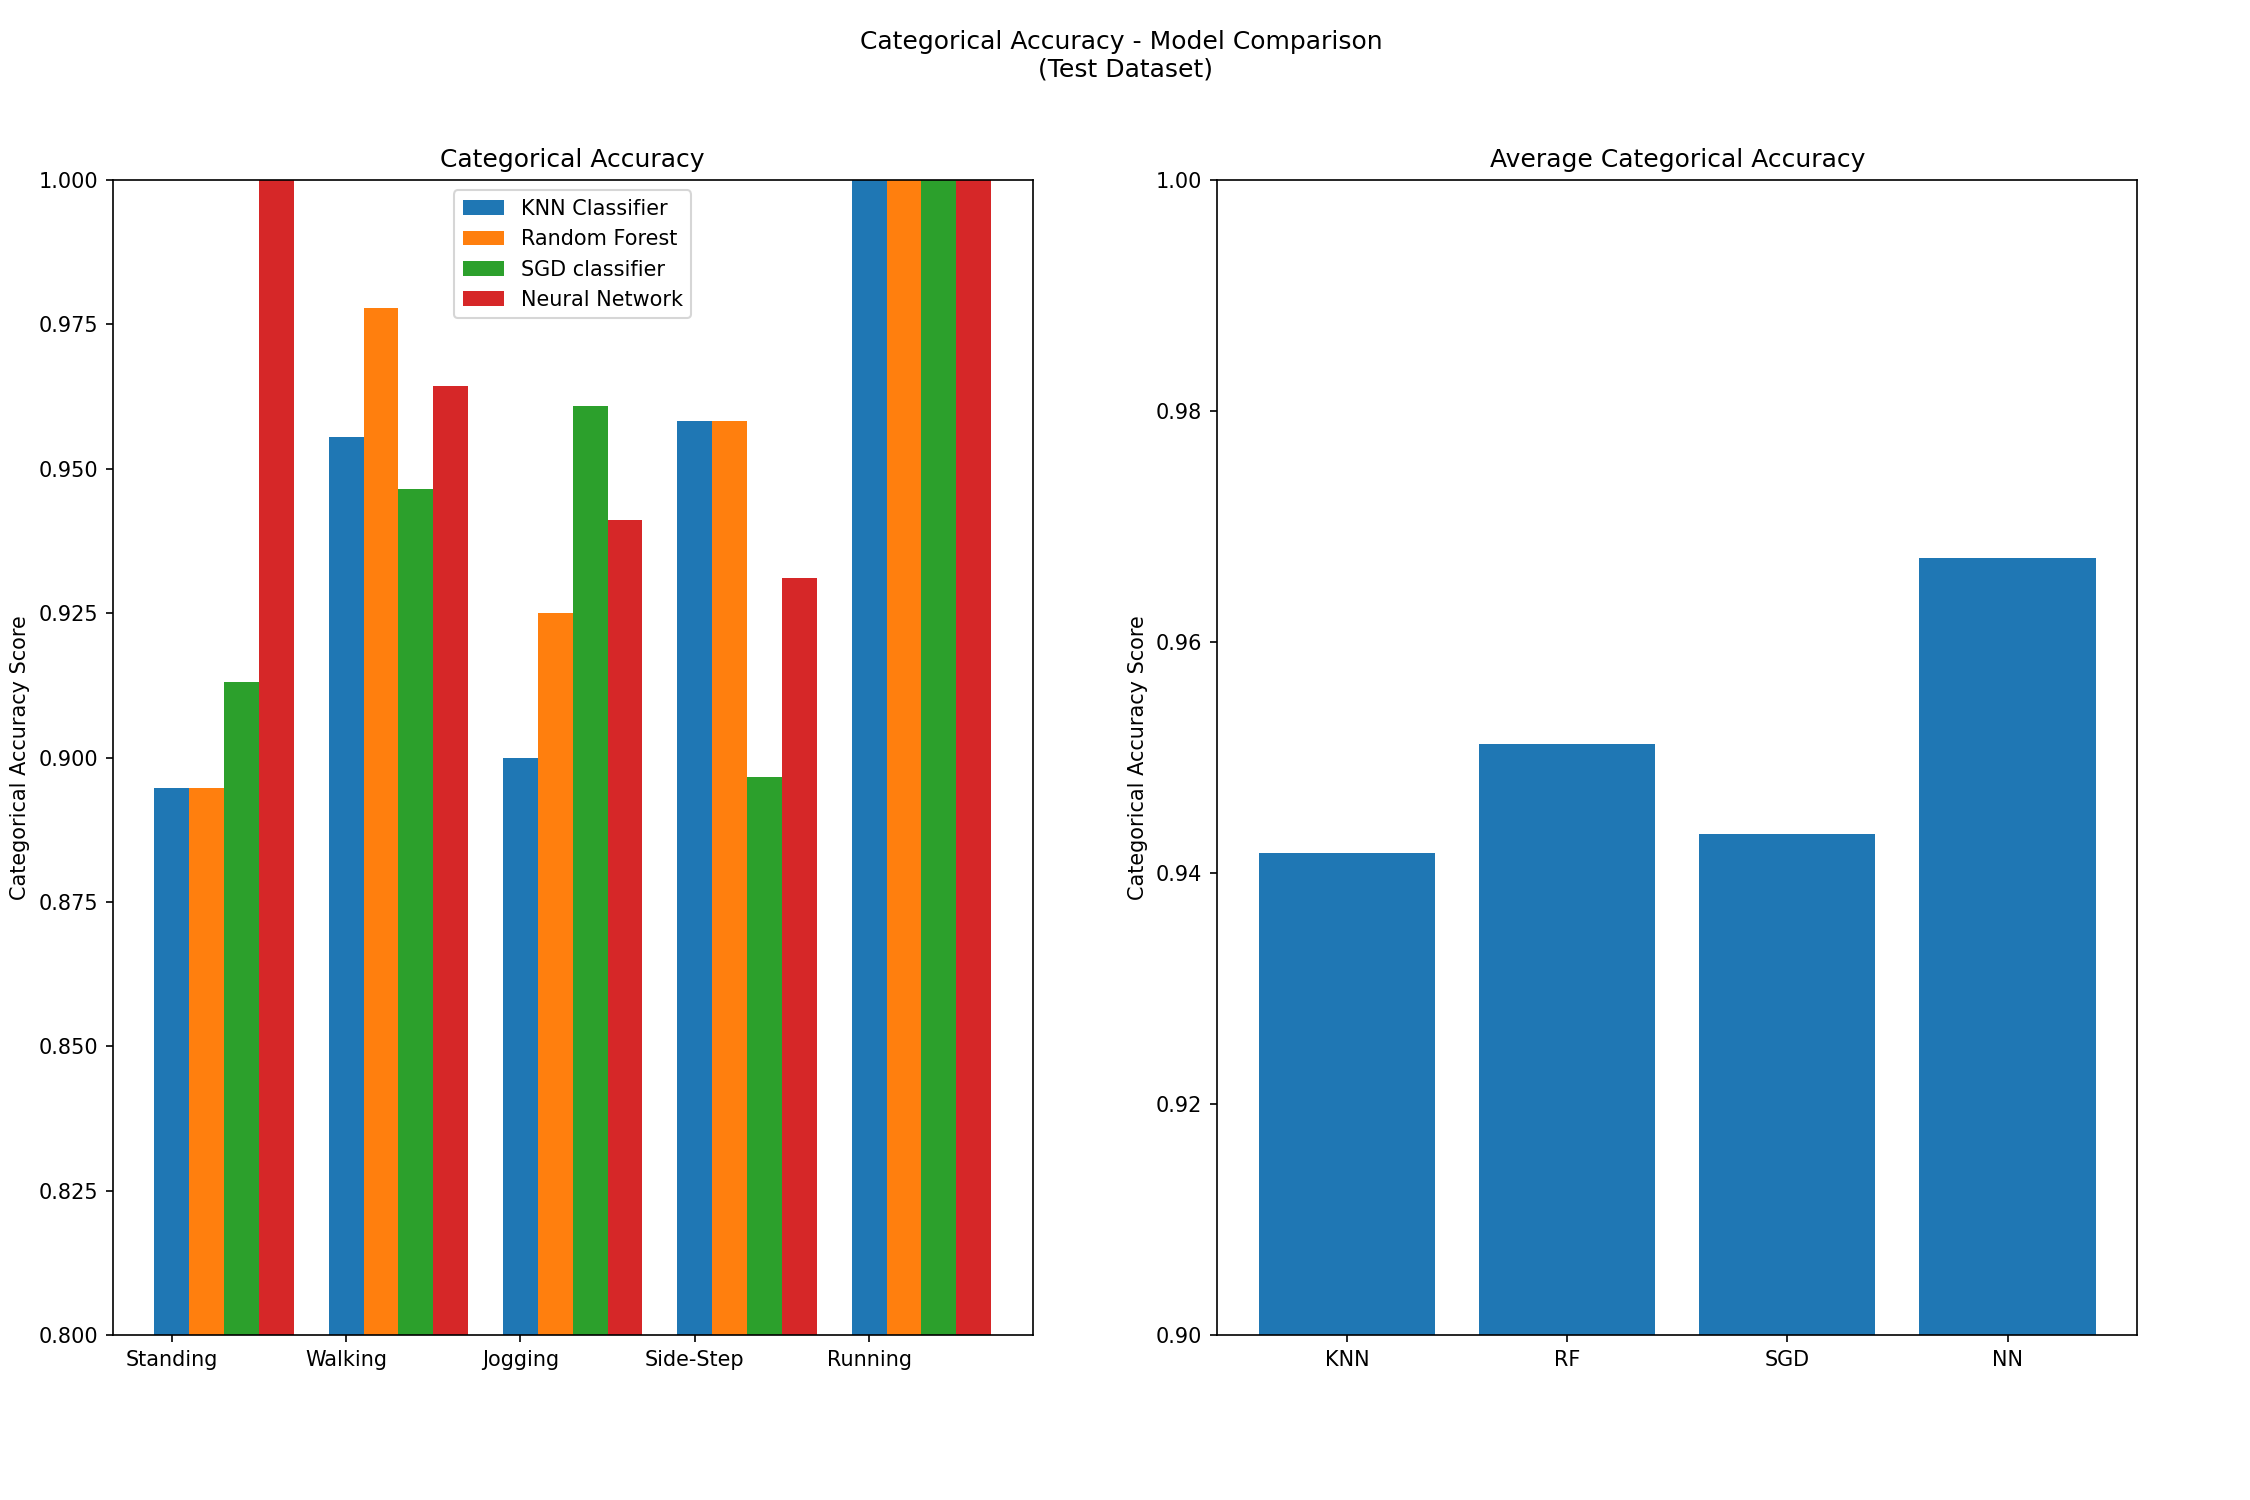

C:\Users\wills\AppData\Local\Temp\ipykernel_5332\4067251099.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["", "Standing", "Walking", "Jogging", "Side-Step", "Running"])


Text(0, 0.5, 'Categorical Accuracy Score')

In [34]:
# chart up categorical accuracy score for each model in histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
fig.suptitle("Categorical Accuracy - Model Comparison \n(Test Dataset)")
fig.subplots_adjust(left=0.05)
fig.subplots_adjust(right=0.95)

# plot categorical accuracy for each classifier
X_axis1 = np.arange(len(knn_cat_accuracy))
#X_axis1 = ["Standing", "Walking", "Jogging", "Side-Step", "Running"]
bar_width = 0.2
ax[0].bar(X_axis1 -0.0, knn_cat_accuracy, bar_width, label="KNN Classifier")
ax[0].bar(X_axis1 +0.2, rf_cat_accuracy, bar_width, label="Random Forest")
ax[0].bar(X_axis1 +0.4, sgd_cat_accuracy, bar_width, label="SGD classifier")
ax[0].bar(X_axis1 +0.6, nn_cat_accuracy, bar_width, label="Neural Network")

ax[0].set_title("Categorical Accuracy")
ax[0].set_ylabel("Categorical Accuracy Score")
ax[0].set_ylim([0.8, 1.0])
# TODO: SET X LABELS FOR EACH CLASS
ax[0].set_xticklabels(["", "Standing", "Walking", "Jogging", "Side-Step", "Running"])
ax[0].legend()

# plot average categorical accuracy for each classifier
X_axis2 = ['KNN', 'RF', 'SGD', 'NN']
avg_cat_accuracy = [np.mean(knn_cat_accuracy), np.mean(rf_cat_accuracy), np.mean(sgd_cat_accuracy), np.mean(nn_cat_accuracy)]
ax[1].bar(X_axis2, avg_cat_accuracy)
ax[1].set_ylim(0.9, 1.0)
ax[1].set_title("Average Categorical Accuracy")
ax[1].set_ylabel("Categorical Accuracy Score")

# Conclusion

Categorical accuracy has been chosen as the metric to compare these 4 models.

All 4 models performed reasonably well based on this metric, with average accuracy scores in the 94-96% range.
All models classified the running activity extremely well, but with some mixed results for other classes.
The RandomForest classifier scored the highest average categorical accuracy, followed closely by the Neural Network.
A small number of incorrect classifications are observed in the confusion matrices for each model, although it is worth noting
false positives and false negatives are far less significant in terms of real world consequences when compared to experiments
such as the poisonous vs edible mushroom classification.

Some points to note for each classifier:
- KNearestNeighbour classifier performance can suffer with unbalanced classes, and is sensitive to outliers in the data.
- RandomForest Classifier is generally a strong performing classifier, and is the top performer on our test set. This classifier is generally fairly robust, not prone to over fitting, but may struggle with extreme outliers.
- StochasticGradientDescent classifier can have difficulty separating on some features due to its linear decision boundaries, but has still achieved reasonable performance in this experiment.
- NeuralNetworks are generally prone to over fitting as shown in the loss and accuracy curves above (I have deliberately trained this model for more epochs to demonstrate the over-fitting). Despite this over-fitting, good performance has still been achieved.

Options to improve model performance:
- Obtain a larger dataset
- Further feature engineering
- Analysis of feature importance
- More rigorous analysis of activity label assignment against video timetrack